## 0 - Import Necessary Modules

In [2]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from wrf import xy_to_ll 

# warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Define Shapefiles

In [6]:
# shapefile paths
ist_shape = r'data/shapefiles/istanbul_without_districts.shp'

shapefile = gpd.read_file(ist_shape)
shapefile.crs

<Compound CRS: EPSG:9707>
Name: WGS 84 + EGM96 height
Axis Info [ellipsoidal|vertical]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- H[up]: Gravity-related height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84
- EGM96 height

# 2. Open WRF data and get LU-Index variable

In [22]:
dt = xr.open_dataset(r'data/wrfinput_d03_LU_INDEX_urban.nc')
dt = dt.rio.write_crs(dt['LU_INDEX'].attrs['pyproj_srs'])
dt = dt.rio.set_spatial_dims(x_dim='west_east', y_dim='south_north')

In [24]:
# projection
lu_index = dt['LU_INDEX'].rio.clip(shapefile.geometry.apply(mapping), shapefile.crs)

# only urban areas
lu_index_urban = lu_index.where(lambda x: x==1)

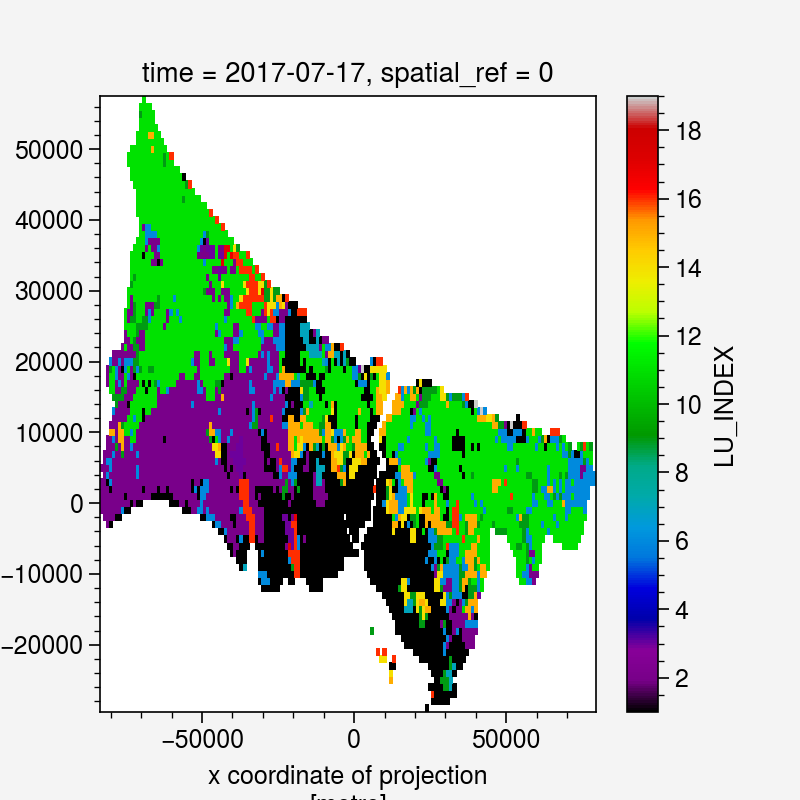

In [25]:
lu_index.plot(cmap='nipy_spectral')

# 3. Calculate Land-use Proportions

In [26]:
lu_index_reshaped = lu_index.values.reshape(-1)
lu_index_notisnan = lu_index_reshaped[~np.isnan(lu_index_reshaped)]

In [27]:
dict(Counter(lu_index_notisnan))

{1.0: 1198,
 16.0: 121,
 9.0: 209,
 7.0: 46,
 15.0: 246,
 14.0: 112,
 6.0: 421,
 2.0: 1119,
 11.0: 1927,
 3.0: 37,
 17.0: 8,
 19.0: 4}

In [28]:
lu_pd = pd.DataFrame(dict(Counter(lu_index_notisnan)), index=['count']) \
                    .T \
                    .reset_index() \
                    .rename(columns={'index':'lu'})

In [29]:
lu_pd['percent'] = lu_pd.apply(lambda row: row['count']/lu_pd['count'] \
                               .sum()*100,
                               axis=1)

In [30]:
lu_pd[['lu', 'percent']].sort_values('percent', ascending=False)#['percent']

,lu,percent
8,11.0,35.370778
0,1.0,21.989721
7,2.0,20.539648
6,6.0,7.727606
4,15.0,4.515419
2,9.0,3.836270
1,16.0,2.220999
5,14.0,2.055800
3,7.0,0.844347
9,3.0,0.679148
